In [540]:
import matplotlib.pyplot as plt
import geopandas as gpd
from   shapely.geometry import Point
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Loading and preparing data</h2>

In [541]:
municipality = gpd.read_file('data/municipality/ABMS_MUNI_polygon.shp')
restaurantBusinesses_df = pd.read_json('data/yelpcleaned/business.json',lines= True)
municipality = municipality.to_crs('epsg:4326')
crs={'init':'EPSG:4326'}
#creating geometry points for restaurants
geometry = [Point(xy) for xy in zip(restaurantBusinesses_df['longitude'], restaurantBusinesses_df['latitude'])]
restaurantBusinesses_gdf = gpd.GeoDataFrame(restaurantBusinesses_df,crs=crs,geometry=geometry)

/home/brian/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<h2>Plot of restaurant locations </h2>

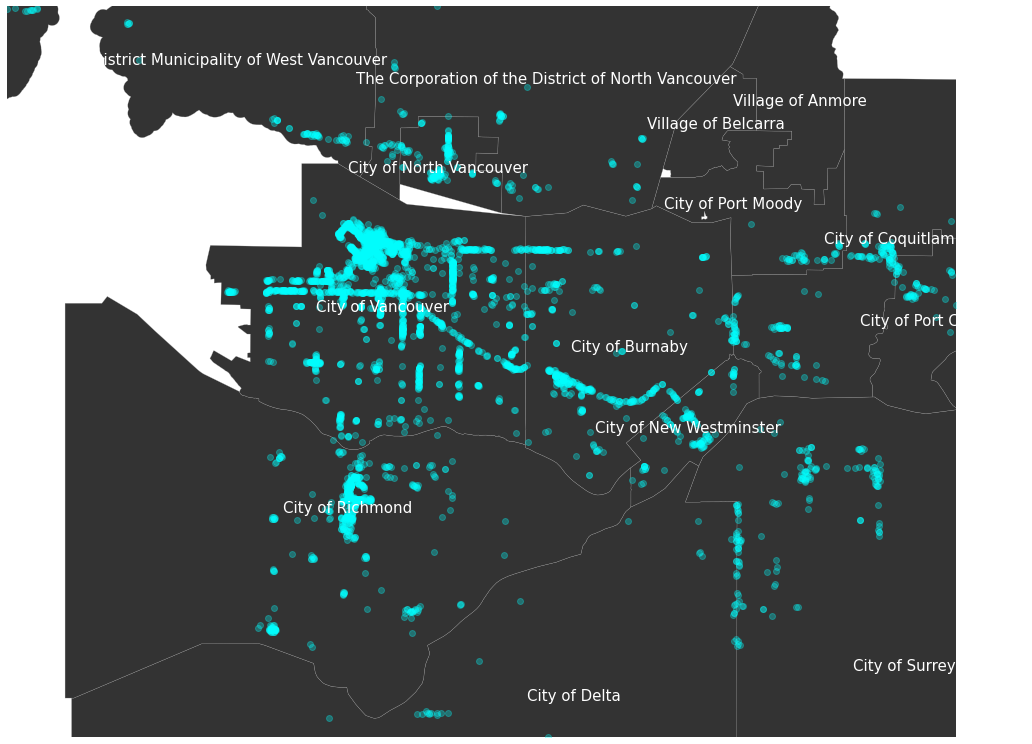

In [542]:
minx, miny, maxx, maxy = restaurantBusinesses_gdf.total_bounds
fig, ax = plt.subplots(figsize=(17,17))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
#Plotting map of cities in BC 
municipality['coords'] = municipality['geometry'].apply(lambda x: x.representative_point().coords[:])
municipality['coords'] = [coords[0] for coords in municipality['coords']]
municipality.plot(ax=ax, facecolor = 'black', edgecolor = 'darkGrey', linewidth = 0.3, alpha =0.8)

#Plotting names of the cities on top of the map
for idx, row in municipality.iterrows():
    plt.annotate(  
                    text=row['AA_NAME'], xy=row['coords'],
                    horizontalalignment='center',
                    verticalalignment='center',
                    
                    transform=ax.transAxes,
                    color = 'white',
                    size = 15
                )
#plotting geometry points of restaurants
restaurantBusinesses_gdf.plot(ax=ax, color='cyan',alpha =0.3);
plt.axis('off');


<h2>Bar plot of 10 Most Common Restaurant Cuisines in BC</h2>

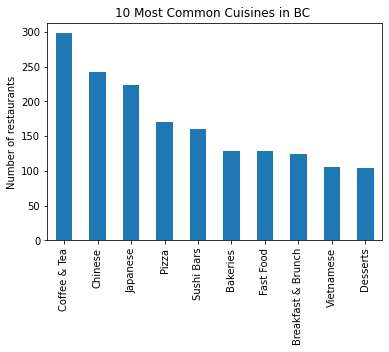

In [543]:
cuisineCounts = restaurantBusinesses_df.groupby(['cuisine']).agg('cuisine').count().reset_index(name="counts")
cuisineCounts = cuisineCounts.sort_values('counts', ascending= False)

#Exclude Cafes, Sandwiches, Specialty Foods
cuisineCounts = cuisineCounts[cuisineCounts['cuisine']!='Cafes']
cuisineCounts = cuisineCounts[cuisineCounts['cuisine']!='Sandwiches']
cuisineCounts = cuisineCounts[cuisineCounts['cuisine']!='Specialty Food']

top_10 = cuisineCounts.head(10)
top_10['counts'].T.plot.bar(subplots=True, title=['10 Most Common Cuisines in BC '], use_index = False)
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 
            top_10['cuisine']);
plt.ylabel('Number of restaurants');


<h2>Bar Plot of the Number of Restaurants by City Name</h2>

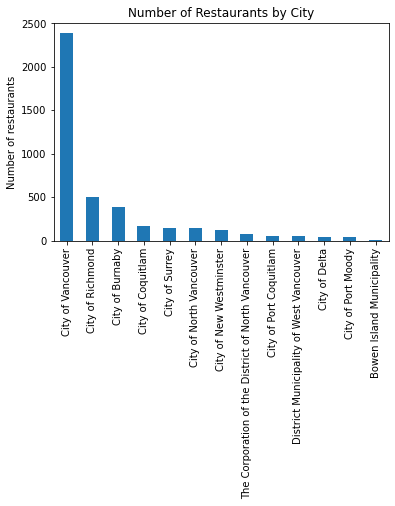

In [544]:
restaurantCounts_byCity = restaurantBusinesses_df.groupby(['city']).agg('city').count()
restaurantCounts_byCity = pd.DataFrame(restaurantCounts_byCity)
restaurantCounts_byCity = restaurantCounts_byCity.rename(columns={'city': 'counts'})
restaurantCounts_byCity = restaurantCounts_byCity.reset_index()
restaurantCounts_byCity = restaurantCounts_byCity.sort_values('counts', ascending= False)
uniqueCityNames_count = np.count_nonzero(restaurantBusinesses_df['city'].unique())
x = list(range(uniqueCityNames_count))
restaurantCounts_byCity['counts'].T.plot.bar(subplots=True, title=['Number of Restaurants by City'], use_index = False)
plt.xticks( x, restaurantCounts_byCity['city']);
plt.ylabel('Number of restaurants');


<h2>Clustering restaurants by location</h2>

Before clustering restaurants by location, we first need to determine the number of clusters (K) to pass into the machine learning algorithm. We discovered that a common way for determining the parameter K is to apply the 'Elbow' method which will result in a graph where the inflection point would be the 'optimal' value for K. 

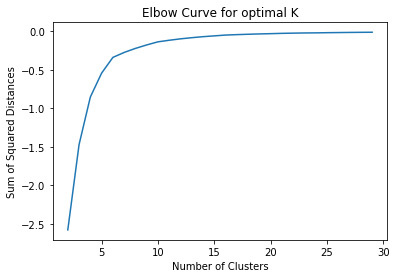

In [545]:
#adapted from: https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1
from sklearn.cluster import KMeans
X=restaurantBusinesses_df.loc[:,['business_id','latitude','longitude']]
#Elbow method to find optimal k for clustering
K_clusters = range(2,30)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = X[['latitude']]
X_axis = X[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve for optimal K')
plt.show()

The Sum of Squared Distances levels off approximately at K ~ 20, therefore we will K=20 as the default number of clusters for clustering restaurants based on their locations. 

In [546]:
kmeans = KMeans(n_clusters = 20, init = 'k-means++', random_state = 5,  max_iter=400)
kmeans.fit(X[X.columns[1:3]]) 
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
labels = kmeans.predict(X[X.columns[1:3]]) 
X.head(10)

,business_id,latitude,longitude,cluster_label
0,3KqpiLDAjeeMmZeU-Il_ng,49.124569,-123.181595,5
1,4Ti8iEFi4EFycP9N7mbaiA,49.267269,-123.069672,4
2,-VVUUPK0ytYjpJ_S76wQYg,49.266541,-123.103745,12
3,w5upfSHsC71wU9vI0irCTQ,49.255810,-123.087532,12
4,4v3pz8_xyIsmX1EAX-AQLA,49.233303,-123.128578,12
5,k7TgLsIoMU0x8O8WVFi0CQ,49.163670,-123.134918,6
6,H1yjEU0KWm3sfuhxB9omOQ,49.239361,-123.053154,15
7,5iq3knhObS_XZ9EhIW1YNQ,49.283329,-123.093971,18
8,_DcUbCJAayLsRtN0mgrqUA,49.283058,-123.109299,18
9,wHUqPSykTimFhHlRpXdqxw,49.263939,-123.167854,9


<h2>Plot restaurants from clusters</h2>

/home/brian/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


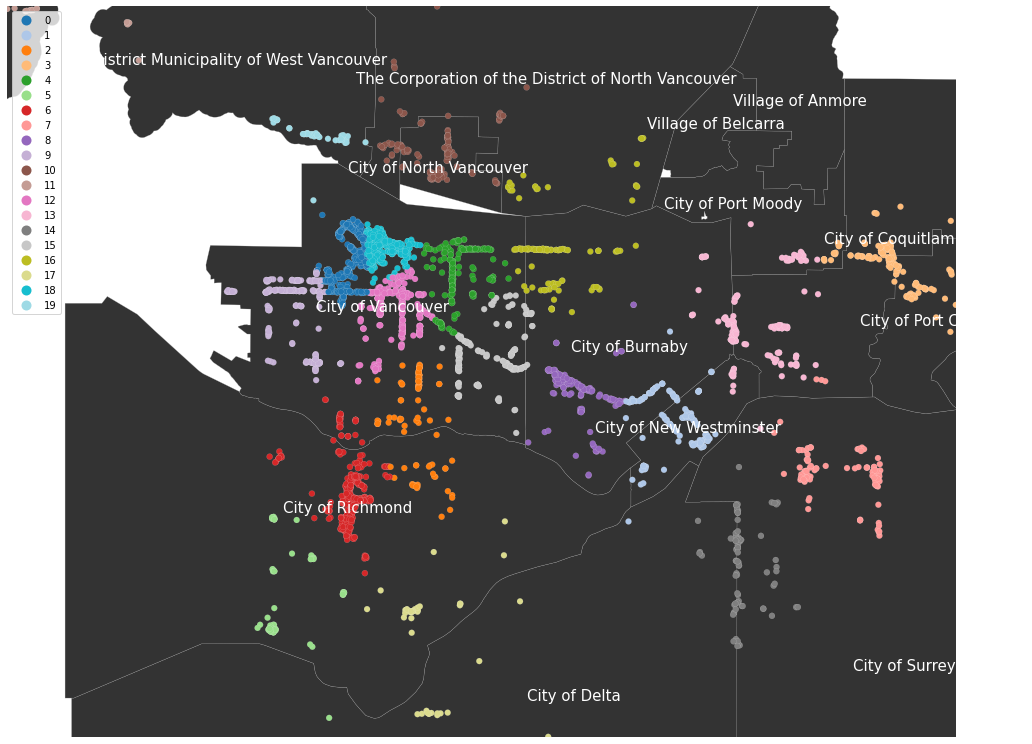

In [547]:
minx, miny, maxx, maxy = restaurantBusinesses_gdf.total_bounds
fig, ax = plt.subplots(figsize=(17,17))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

#Plotting map of cities in BC 
municipality.plot(ax=ax, facecolor = 'black', edgecolor = 'darkGrey', linewidth = 0.3, alpha =0.8)
geo_df = gpd.GeoDataFrame(X.drop(['longitude', 'latitude'], axis=1), 
crs={'init': 'epsg:4326'}, geometry=[Point(xy) for xy in zip(X.longitude, X.latitude)])

#Plotting names of cities on top of the map
for idx, row in municipality.iterrows():
    plt.annotate(  
                    text=row['AA_NAME'], xy=row['coords'],
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes,
                    color = 'white',
                    size = 15
                );

geo_df.plot(ax = ax , categorical = True, column = 'cluster_label', linewidth = 0.1,cmap='tab20', edgecolor= 'white', legend=True);
plt.axis('off');


<h2>Analyzing Clusters</h2>

In [548]:
#combining dataframe to obtain label for each restaurant
restaurantBusinesses_df = restaurantBusinesses_df.merge(X.drop(['latitude', 'longitude'],axis=1), on = ['business_id'])
restaurantBusinesses_df.head(10)


,cuisine,business_id,name,address,city,state,latitude,longitude,stars,review_count,geometry,cluster_label
0,Japanese,3KqpiLDAjeeMmZeU-Il_ng,Yokohama Teppanyaki,"12251 Number 1 Road, Suite 140",City of Richmond,BC,49.124569,-123.181595,2.5,80,POINT (-123.18159 49.12457),5
1,Grocery,4Ti8iEFi4EFycP9N7mbaiA,Vapester Smoke Shop,1961 Commercial Dr,City of Vancouver,BC,49.267269,-123.069672,4.5,9,POINT (-123.06967 49.26727),4
2,Chinese,-VVUUPK0ytYjpJ_S76wQYg,Peaceful Restaurant,43 E 5th Avenue,City of Vancouver,BC,49.266541,-123.103745,3.0,107,POINT (-123.10374 49.26654),12
3,Indian,w5upfSHsC71wU9vI0irCTQ,Kilimanjaro Snack House and Catering,789 Kingsway,City of Vancouver,BC,49.255810,-123.087532,4.0,21,POINT (-123.08753 49.25581),12
4,Delis,4v3pz8_xyIsmX1EAX-AQLA,Omnitsky Kosher,5775 Oak Street,City of Vancouver,BC,49.233303,-123.128578,3.5,32,POINT (-123.12858 49.23330),12
5,Chinese,k7TgLsIoMU0x8O8WVFi0CQ,Golden Paramount Seafood Restaurant,8111 Anderson Road,City of Richmond,BC,49.163670,-123.134918,3.5,36,POINT (-123.13492 49.16367),6
6,Chinese,H1yjEU0KWm3sfuhxB9omOQ,Come Along Seafood Restaurant,2550 Kingsway,City of Vancouver,BC,49.239361,-123.053154,3.5,54,POINT (-123.05315 49.23936),15
7,Dim Sum,5iq3knhObS_XZ9EhIW1YNQ,Gah Lok Dim Sum,461 Powell Street,City of Vancouver,BC,49.283329,-123.093971,4.5,9,POINT (-123.09397 49.28333),18
8,Ethiopian,_DcUbCJAayLsRtN0mgrqUA,Afro-Canadian Restaurant,324 Cambie Street,City of Vancouver,BC,49.283058,-123.109299,4.0,35,POINT (-123.10930 49.28306),18
9,Desserts,wHUqPSykTimFhHlRpXdqxw,Baroness,2790 W Broadway,City of Vancouver,BC,49.263939,-123.167854,4.5,52,POINT (-123.16785 49.26394),9


Calculating total number of each cuisine for each cluster

In [549]:
uniqueCuisines = restaurantBusinesses_df['cuisine'].unique()
restaurantsCountByCuisineType = pd.DataFrame(restaurantBusinesses_df.groupby(['cluster_label', 'cuisine']).agg('cuisine').count())
restaurantsCountByCuisineType = restaurantsCountByCuisineType.rename(columns={"cuisine":"counts"})

restaurantsCountByCuisineType= restaurantsCountByCuisineType.reset_index()

restaurantsCountByCuisineType = (restaurantsCountByCuisineType.assign(cuisine=pd.Categorical(restaurantsCountByCuisineType['cuisine'], categories=uniqueCuisines))
   .pivot_table(index=     'cuisine',
                columns =  'cluster_label',
                values=    'counts',
                dropna=False, fill_value=0)
   .to_dict('list')
)
restaurants_countByCuisineType = pd.DataFrame.from_dict(restaurantsCountByCuisineType)
restaurants_countByCuisineType = restaurants_countByCuisineType.transpose()
restaurants_countByCuisineType.columns= (uniqueCuisines.tolist())
restaurants_countByCuisineType = restaurants_countByCuisineType.reset_index()
restaurants_countByCuisineType = restaurants_countByCuisineType.rename(columns={"index":"cluster_label"})
restaurants_countByCuisineType = restaurants_countByCuisineType.set_index('cluster_label')
restaurants_countByCuisineType = restaurants_countByCuisineType.drop(columns=['Grocery'])

restaurants_countByCuisineType.head(5)

,Japanese,Chinese,Indian,Delis,Dim Sum,Ethiopian,Desserts,Sushi Bars,Fast Food,Health Markets,...,Brasseries,Tacos,Acai Bowls,Sri Lankan,Argentine,Hong Kong Style Cafe,Kebab,Themed Cafes,Moroccan,Distilleries
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,47,20,14,9,2,0,14,21,19,1,...,0,0,0,0,0,0,0,0,2,0
1,5,9,8,0,1,0,4,8,4,0,...,0,0,0,0,0,0,0,0,0,0
2,1,8,8,0,0,0,3,2,4,0,...,0,0,0,0,0,0,0,0,0,0
3,10,6,4,2,1,0,3,9,5,2,...,0,0,0,0,0,0,1,1,0,0
4,9,8,4,2,4,2,6,10,2,0,...,0,0,0,1,0,0,0,0,0,0


Representing each cuisine as frequency by dividing each clusters' cuisine count by the total number of cuisines in that cluster 

In [550]:

#count the number of each cluster's total cuisines
restaurants_countByCuisineType['total_cuisines'] = restaurants_countByCuisineType.sum(axis=1)
unique_cuisines = uniqueCuisines[uniqueCuisines!='Grocery']
#calculate f
restaurants_countByCuisineType[unique_cuisines] = restaurants_countByCuisineType[unique_cuisines].div(restaurants_countByCuisineType['total_cuisines'],axis=0)
restaurants_countByCuisineType.head(5)

,Japanese,Chinese,Indian,Delis,Dim Sum,Ethiopian,Desserts,Sushi Bars,Fast Food,Health Markets,...,Tacos,Acai Bowls,Sri Lankan,Argentine,Hong Kong Style Cafe,Kebab,Themed Cafes,Moroccan,Distilleries,total_cuisines
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,0.074960,0.031898,0.022329,0.014354,0.003190,0.00000,0.022329,0.033493,0.030303,0.001595,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00319,0.0,627
1,0.033113,0.059603,0.052980,0.000000,0.006623,0.00000,0.026490,0.052980,0.026490,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,151
2,0.010309,0.082474,0.082474,0.000000,0.000000,0.00000,0.030928,0.020619,0.041237,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,97
3,0.068966,0.041379,0.027586,0.013793,0.006897,0.00000,0.020690,0.062069,0.034483,0.013793,...,0.0,0.0,0.000000,0.0,0.0,0.006897,0.006897,0.00000,0.0,145
4,0.036585,0.032520,0.016260,0.008130,0.016260,0.00813,0.024390,0.040650,0.008130,0.000000,...,0.0,0.0,0.004065,0.0,0.0,0.000000,0.000000,0.00000,0.0,246


Top 10 Most Common Cuisine Types for each Cluster

In [551]:
restaurants_countByCuisineType = restaurants_countByCuisineType.drop(['total_cuisines'],axis=1)
cuisine_ranks =(restaurants_countByCuisineType.rank(axis=1, ascending=False).astype(int))
i = np.argsort(cuisine_ranks.to_numpy(),axis=1)
r = pd.DataFrame(cuisine_ranks.columns[i], index = cuisine_ranks.index, columns = range(1,i.shape[1]+1))
r.index.name = 'Cluster number'
r = r.iloc[:, : 10]
r.add_suffix('\'Most Common Cuisine')
r.to_csv('test')

/tmp/ipykernel_4517/1538272269.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  r = pd.DataFrame(cuisine_ranks.columns[i], index = cuisine_ranks.index, columns = range(1,i.shape[1]+1))


In [552]:
# #calculating average rating per cluster
# average_ratings_per_cluster = restaurantBusinesses_df.groupby('cluster_label')
# average_ratings_per_cluster = average_ratings_per_cluster.agg('stars').mean().reset_index()
# average_ratings_per_cluster = average_ratings_per_cluster.rename(columns={
#                 "stars":"mean_rating"})
# average_ratings_per_cluster